In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
data=pd.read_csv("/content/drive/MyDrive/Fraud.csv")

In [4]:
data.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


In [5]:
data.shape

(6362620, 11)

In [6]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## **Outliers**

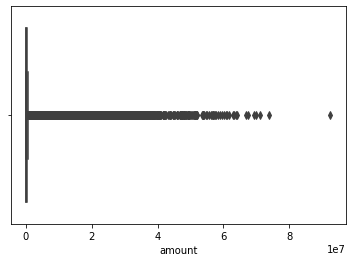

In [7]:
sns.boxplot(x=data["amount"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


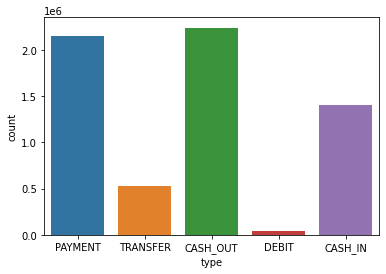

In [8]:
sns.countplot(data['type'])

In [9]:
print("Total Unique Values in nameOrig", data['nameOrig'].nunique())

Total Unique Values in nameOrig 6353307


In [10]:
print("Total Unique Values in nameDest", data['nameDest'].nunique())

Total Unique Values in nameDest 2722362


## **Observations**:-

1.Amount Column has Outliers

2.Debit type transaction count is very small

3.Total Unique values in nameOrig is 6353307

4.Total Unique values in nameDest is 2722362

## **Multi-Collinearity Checking**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

data_without_text=pd.DataFrame({"step":data.step,
                                "amount":data.amount,
                               "oldbalanceOrg":data.oldbalanceOrg,
                               "newbalanceOrig":data.newbalanceOrig,
                               "oldbalanceDest":data.oldbalanceDest,
                               "newbalanceDest":data.newbalanceDest,
                               "isFraud":data.isFraud,
                               "isFlaggedFraud":data.isFlaggedFraud})
vif_data = pd.DataFrame()
vif_data["feature"] = data_without_text.columns
  
vif_data["VIF"] = [variance_inflation_factor(data_without_text.values, i)
                          for i in range(len(data_without_text.columns))]
  
print(vif_data)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


          feature         VIF
0            step    1.191094
1          amount    4.078952
2   oldbalanceOrg  544.053103
3  newbalanceOrig  546.346008
4  oldbalanceDest   72.895522
5  newbalanceDest   84.584619
6         isFraud    1.188386
7  isFlaggedFraud    1.002546


## **Observations**

**Issue**:

 1.Here oldbalanceorg and newbalanceorig has high vif so these are creating multi-collinearity

 2.oldbalanceDest and newbalanceDest also has multi-collinearity.


**Prevention**:

1.we will remove oldbalnceorg and newbalaceorig and and add the difference of  column in the data set.

2.do the same thing for this also

In [11]:
from tqdm import tqdm

In [12]:
old_balance=data["oldbalanceOrg"]
new_balance=data["newbalanceOrig"]
bal_change=[] #if balace deduct then 1 else 0
for i in tqdm(range(len(old_balance))):
  diff=new_balance[i]-old_balance[i]
  if diff>0:
      bal_change.append(0)
  else:
      bal_change.append(1)
  

100%|██████████| 6362620/6362620 [00:39<00:00, 160085.18it/s]


In [13]:
dest_old=data["oldbalanceDest"]
dest_new=data["newbalanceDest"]
dest_bal_change=[]
dest_bal=[]
for i in tqdm(range(len(dest_old))):
    diff=dest_new[i]-dest_old[i]
    if diff>0:
        dest_bal_change.append(0)
        dest_bal.append(abs(diff))
    else:
        dest_bal_change.append(1)
        dest_bal.append(abs(diff))

100%|██████████| 6362620/6362620 [00:42<00:00, 150361.78it/s]


In [14]:
data["source_bal_change"]=bal_change
data["destination"]=dest_bal
data["dest_bal_chnage"]=dest_bal_change

In [15]:
data.drop(["oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"],axis=1,inplace=True)

In [16]:
data.head(2)

,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,source_bal_change,destination,dest_bal_chnage
0,1,PAYMENT,9839.64,C1231006815,M1979787155,0,0,1,0.0,1
1,1,PAYMENT,1864.28,C1666544295,M2044282225,0,0,1,0.0,1


## **Checking Colinearity on Data after Featurization** 

In [ ]:
data_without_text=pd.DataFrame({"step":data.step,
                                "amount":data.amount,
                                "bal_change":bal_change,
                              
                               "bal_dif":bal,
                                "dest_bal_change":dest_bal_change,
                               "dest_bal_difference":dest_bal,
                                
                               "isFraud":data.isFraud,
                               "isFlaggedFraud":data.isFlaggedFraud})
vif_data = pd.DataFrame()
vif_data["feature"] = data_without_text.columns
  
vif_data["VIF"] = [variance_inflation_factor(data_without_text.values, i)
                          for i in range(len(data_without_text.columns))]
  
print(vif_data)

               feature       VIF
0                 step  3.183617
1               amount  4.740347
2           bal_change  2.588790
3              bal_dif  1.540877
4      dest_bal_change  1.902094
5  dest_bal_difference  4.390640
6              isFraud  1.173016
7       isFlaggedFraud  1.003006


In [17]:
result=data["isFraud"]
data.drop("isFraud",axis=1,inplace=True)

In [57]:
True_fraud=np.sum(result==1)
False_fraud=np.sum(result==0)
print(True_fraud)
print(False_fraud)

8213
6354407


## **Observation**
1.we can clealy see that here the data is imbalaced

2.We will do downsampling on the data basically here the size of True_fraud and False_fraud will be same

3.But Firsly we will check with imabalance Data

## **Working With Imbalanced Data**

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,result,test_size=0.20,random_state=42)

In [19]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5090096, 9)
(1272524, 9)
(5090096,)
(1272524,)


## **Categorical Data**

In [20]:
from sklearn import preprocessing   #LabelEncoder
le = preprocessing.LabelEncoder()
le.fit(data["type"])
train_type=le.transform(x_train["type"])
test_type=le.transform(x_test["type"])


In [21]:
le2=preprocessing.LabelEncoder()
le2.fit(data["nameOrig"])
train_nameOrig=le2.transform(x_train["nameOrig"])
test_nameOrig=le2.transform(x_test["nameOrig"])

In [22]:
le3=preprocessing.LabelEncoder()
le3.fit(data["nameDest"])
train_nameDest=le3.transform(x_train["nameDest"])
test_nameDest=le3.transform(x_test["nameDest"])

In [23]:
x_train.drop(["type","nameOrig","nameDest"],axis=1,inplace=True)

In [24]:
x_train["type"]=train_type
x_train["nameOrig"]=train_nameOrig
x_train["nameDest"]=train_nameDest

In [25]:
x_train.head(2)

,step,amount,isFlaggedFraud,source_bal_change,destination,dest_bal_chnage,type,nameOrig,nameDest
6271196,619,386385.08,0,0,386385.08,1,0,4449199,289167
1888243,164,212458.78,0,0,212458.78,1,0,5813773,204382


In [26]:
x_test.drop(["type","nameOrig","nameDest"],axis=1,inplace=True)

In [27]:
x_test["type"]=test_type
x_test["nameOrig"]=test_nameOrig
x_test["nameDest"]=test_nameDest

In [28]:
x_test.head(2)

,step,amount,isFlaggedFraud,source_bal_change,destination,dest_bal_chnage,type,nameOrig,nameDest
3737323,278,330218.42,0,0,330218.42,1,0,5144186,523341
264914,15,11647.08,0,1,0.00,1,3,868156,1849210


 ## Here i am going to use Xgboost for train the model 
Beacuse:

  1.Feature scaling is not important in xgboost as here amount can be in any currency

  2.in above we see that amount Data has very much outliers and xgboost is not influenced by outliers 



### **HyperParameter Tuning on xgboost**

In [29]:
import xgboost as xgb
xgb_model  = xgb.XGBClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {"max_depth":[1,2,3,4] }
clf = GridSearchCV(xgb.XGBClassifier(), parameters, cv=3, scoring='roc_auc',return_train_score=True,n_jobs=-1)
clf.fit(x_train,y_train)


[18:29:26] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4]}, return_train_score=True,
             scoring='roc_auc')

Best Parameter {'max_depth': 4}


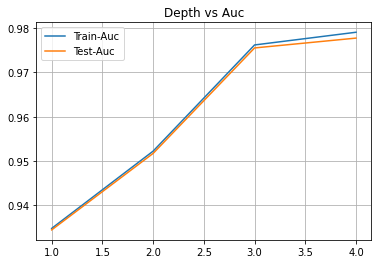

In [ ]:
import matplotlib.pyplot as plt
max_depth=[1,2,3,4]
df=pd.DataFrame.from_dict(clf.cv_results_)
train_auc=df['mean_train_score']
test_auc=df['mean_test_score']
plt.grid()
plt.plot(max_depth,train_auc,label="Train-Auc")
plt.plot(max_depth,test_auc,label="Test-Auc")
plt.legend()
plt.title("Depth vs Auc")
print("Best Parameter",clf.best_params_)


## **Model** 

[06:32:00] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


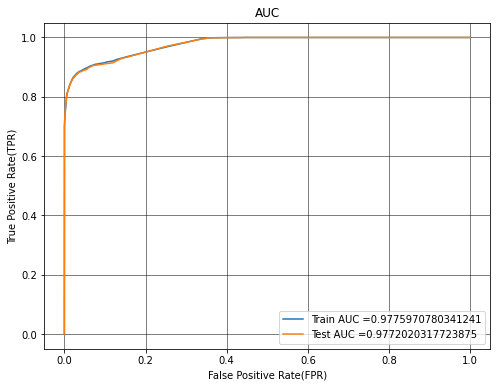

In [33]:
from sklearn.metrics import roc_curve, auc

model_set=xgb.XGBClassifier(max_depth=4)
model_set.fit(x_train,y_train)
y_train_probs = model_set.predict_proba(x_train)[:,1] # converting train and test output into probability
y_test_probs= model_set.predict_proba(x_test)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(8,6))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(color='black',lw=0.5)


In [45]:
def find_best_threshold(threshould, fpr, tpr):
 t = threshould[np.argmax(tpr*(1-fpr))]
 print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
 return t
def predict_with_best_t(proba, threshould):
  prediction=[]
  for i in proba:
    if i>=threshould:
      prediction.append(1)
    else:
      prediction.append(0)
  return prediction

In [47]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
l=predict_with_best_t(y_train_probs, best_t)
k=confusion_matrix(y_train,l)
print(k)

the maximum value of tpr*(1-fpr) 0.8530069023815695 for threshold 0.001
Train confusion matrix
[[4913885  169618]
 [    775    5818]]


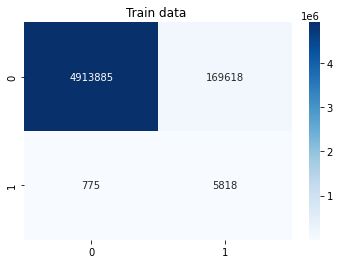

In [48]:
import matplotlib.pyplot as plt 
import seaborn as sns
plt.title("Train data ")
sns.heatmap(k, annot=True,fmt="d",cmap='Blues')

In [49]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
print("Test confusion matrix")
l=predict_with_best_t(y_test_probs, best_t)
k=confusion_matrix(y_test,l)
print(k)

the maximum value of tpr*(1-fpr) 0.8512090951221811 for threshold 0.001
Test confusion matrix
[[1226399   44505]
 [    191    1429]]


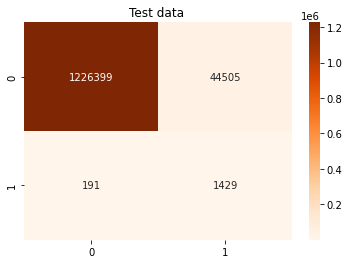

In [50]:
import matplotlib.pyplot as plt 
import seaborn as sns
plt.title("Test data ")
sns.heatmap(k, annot=True,fmt="d",cmap='Oranges')

##**Observations**

1.Here the accuracy is very high for both  train data and test data

2.But if we check the confusion matrix we can observe that number of turely classified "isfraud" is very less

3.As we it is an imbalaced data we can't totaly depend on this output for this we have to make the daat balance then we have check the output 

## **Working with balanced Data**

In [63]:
from imblearn.under_sampling import RandomUnderSampler  
                                                        #Doing Under sampling to make data balance
under_sampler = RandomUnderSampler()
X_res, y_res = under_sampler.fit_resample(data,result)

In [67]:
True_fraud=np.sum(y_res==1)
False_fraud=np.sum(y_res==0)
print(True_fraud)
print(False_fraud)

8213
8213


In [68]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_res,y_res,test_size=0.20,random_state=42)

In [69]:
le = preprocessing.LabelEncoder()
le.fit(data["type"])
train_type=le.transform(x_train["type"])
test_type=le.transform(x_test["type"])


In [70]:
le2=preprocessing.LabelEncoder()
le2.fit(data["nameOrig"])
train_nameOrig=le2.transform(x_train["nameOrig"])
test_nameOrig=le2.transform(x_test["nameOrig"])

In [71]:
le3=preprocessing.LabelEncoder()
le3.fit(data["nameDest"])
train_nameDest=le3.transform(x_train["nameDest"])
test_nameDest=le3.transform(x_test["nameDest"])

In [72]:
x_train.drop(["type","nameOrig","nameDest"],axis=1,inplace=True)

In [73]:
x_train["type"]=train_type
x_train["nameOrig"]=train_nameOrig
x_train["nameDest"]=train_nameDest

In [74]:
x_test.drop(["type","nameOrig","nameDest"],axis=1,inplace=True)

In [75]:
x_test["type"]=test_type
x_test["nameOrig"]=test_nameOrig
x_test["nameDest"]=test_nameDest

In [76]:
import xgboost as xgb
xgb_model  = xgb.XGBClassifier()

In [79]:
from sklearn.model_selection import GridSearchCV
parameters = {"max_depth":[1,2,3,4] }
clf = GridSearchCV(xgb.XGBClassifier(), parameters, cv=3, scoring='roc_auc',return_train_score=True,n_jobs=-1)
clf.fit(x_train,y_train)


GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4]}, return_train_score=True,
             scoring='roc_auc')

Best Parameter {'max_depth': 4}


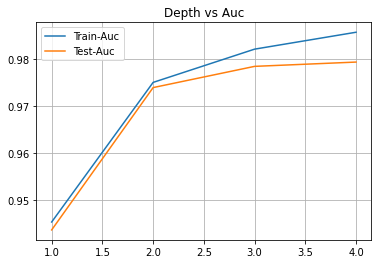

In [80]:
import matplotlib.pyplot as plt
max_depth=[1,2,3,4]
df=pd.DataFrame.from_dict(clf.cv_results_)
train_auc=df['mean_train_score']
test_auc=df['mean_test_score']
plt.grid()
plt.plot(max_depth,train_auc,label="Train-Auc")
plt.plot(max_depth,test_auc,label="Test-Auc")
plt.legend()
plt.title("Depth vs Auc")
print("Best Parameter",clf.best_params_)


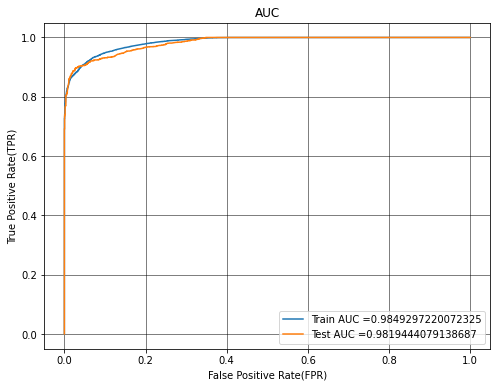

In [81]:
from sklearn.metrics import roc_curve, auc

model_set=xgb.XGBClassifier(max_depth=4)
model_set.fit(x_train,y_train)
y_train_probs = model_set.predict_proba(x_train)[:,1] # converting train and test output into probability
y_test_probs= model_set.predict_proba(x_test)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(8,6))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(color='black',lw=0.5)


In [82]:
def find_best_threshold(threshould, fpr, tpr):
 t = threshould[np.argmax(tpr*(1-fpr))]
 print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
 return t
def predict_with_best_t(proba, threshould):
  prediction=[]
  for i in proba:
    if i>=threshould:
      prediction.append(1)
    else:
      prediction.append(0)
  return prediction

In [83]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
l=predict_with_best_t(y_train_probs, best_t)
k=confusion_matrix(y_train,l)
print(k)

the maximum value of tpr*(1-fpr) 0.8671779899503448 for threshold 0.343
Train confusion matrix
[[6185  379]
 [ 524 6052]]


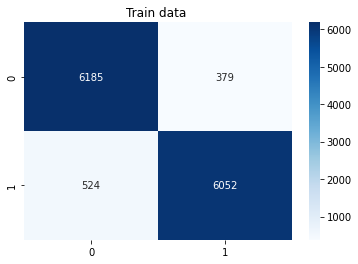

In [84]:
import matplotlib.pyplot as plt 
import seaborn as sns
plt.title("Train data ")
sns.heatmap(k, annot=True,fmt="d",cmap='Blues')

In [85]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
print("Test confusion matrix")
l=predict_with_best_t(y_test_probs, best_t)
k=confusion_matrix(y_test,l)
print(k)

the maximum value of tpr*(1-fpr) 0.871845101138655 for threshold 0.494
Test confusion matrix
[[1601   48]
 [ 167 1470]]


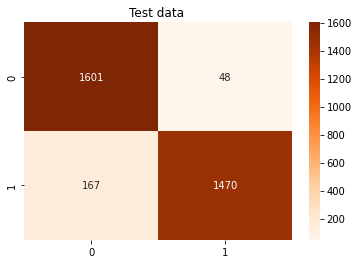

In [86]:
import matplotlib.pyplot as plt 
import seaborn as sns
plt.title("Test data ")
sns.heatmap(k, annot=True,fmt="d",cmap='Oranges')

## **Observations**

1.Here accuracy is very high

2.here from confusion matrix we can conclude that has very good value in Truepositive and TrueNegetive.

3.as it is a balanced data we can say that it will work well in unseen data

4.For prevention we should look into the FN values like if it is very high then we have add some other system the work on